# Hyperparameter Tuning

## Modifying Notebook display

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    .container#notebook-container    { width: 95%;}
    div#menubar-container     { width: 95%; }
    div#maintoolbar-container { width: 95%; }
</style>
<script>
    document.getElementById("notebook-container").style.margin = "auto";
</script>
"""))

## Importing Dependencies

In [2]:
# Python Standard Libraries for importing data from binary file
import time    #for calculating time

#core packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse

#custom module
from  dataset import load_dataset, train_dev_split, prep_dataset

from ffnn import init_layers, init_hyperParams
from ffnn import train, evaluate

from ModelUtils import convert_time
from ModelUtils import save_model, load_model



np.random.seed(1)
%matplotlib inline

## Preparing Dataset

In [3]:
#loading dataset
dataset_size_in_per = 25
train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

#splitting train dev set
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

#preprocessing dataset
train_x_norm, train_y_encoded = prep_dataset(train_x_split, train_y_split, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")

No destination directory exists to load the data from:
Creating 'dataset/mnist/' as a new directory...


train-images-idx3-ubyte.gz: downloading...
9.453 MB  [9.453 MB done ==========> 100%]
train-labels-idx1-ubyte.gz: downloading...
0.028 MB  [0.028 MB done ==========> 100%]
t10k-images-idx3-ubyte.gz: downloading...
1.572 MB  [1.572 MB done ==========> 100%]
t10k-labels-idx1-ubyte.gz: downloading...
0.004 MB  [0.004 MB done ==========> 100%]

Dataset download succeeded...

Decompressing the mnist dataset...
Dataset decompression succeeded...
Data			 Before Processing	 After Processing
Training Set Images:	(12750, 28, 28)		(784, 12750)
Training Set Labels:	(12750, 1)		(10, 12750)
Dev Set Images:		(2250, 28, 28)		(784, 2250)
Dev Set Labels:		(2250, 1)		(10, 2250)
Test Set Images:	(2500, 28, 28)		(784, 2500)
Test Set Labels:	(2500, 1)		(10, 2500)


## Generating Samples

In [4]:
def sample_network_architecture(hidden_layers_rng, hidden_units_rng, sample_size, hidden_units_size = 'variable', mixed_mode = False):
    
    sample_architectures = []
    
    #generating sample space for hidden units. hidden units will be choosen from this sample space only
    hidden_units_sample_space = []
    for i in range(hidden_units_rng[0], hidden_units_rng[1]):
        if i %  4 == 0: #reducing the sample space by 4x yet covering the size of hidden units in most of the literature (unit size multiple of 4)
            hidden_units_sample_space.append(i)
    
    while(len(sample_architectures) != sample_size):
        #generating the number of hidden layers
        hidden_layer = np.random.randint(low = hidden_layers_rng[0], high = hidden_layers_rng[1])
        hidden_units = []
        
        #randomizing the variable and constant hidden units size mode
        if mixed_mode:
            num_hidden_units = np.random.choice(['constant','variable'])
        
        if hidden_units_size == 'variable': 
            #generating variable size hidden units based on number of hidden layers 
            for num_layer in range(hidden_layer):
                hidden_unit = np.random.choice(hidden_units_sample_space)
                hidden_units.append(hidden_unit)
        elif hidden_units_size == 'constant':
            #generating constant number of hidden units based on the number of hidden layers
            hidden_unit = np.random.choice(hidden_units_sample_space)
            hidden_units = [hidden_unit for x in range(hidden_layer)]

        else:
            raise ValueError("Size of hidden units can be variable or constant only.")
        
        sample_architectures.append(sorted(hidden_units,reverse = True))
        
    assert(len(sample_architectures) == sample_size) , 'Samples less than required'
    
    return sample_architectures

In [5]:
def sample_hyperParams(hParam_type, rng, sample_size):

    sample = []
    
    lower_range = rng[0]
    higher_range = rng[1]
    
    
    for i in range(sample_size):
        if hParam_type == "learning_rate":
            r = np.random.uniform(lower_range,higher_range)
            p = 10 ** r
            sample.append(p)
        elif hParam_type == "minibatch_size":
            s = np.random.randint(low = lower_range, high = higher_range)
            sample.append(s)
        elif hParam_type == "keep_probs":
            s = np.random.choice(rng)
            sample.append(s)
        else:
            raise ValueError("Sampling of only learning rate and minibatch size is possible for now")
            
    assert(len(sample) == sample_size)
    
    return sample


In [6]:
def test_sample_network_architecture():
    hidden_layers_rng = [1,3]
    hidden_units_rng = [200,1000]
    sample_size = 10
    archs = sample_network_architecture(hidden_layers_rng, hidden_units_rng, sample_size, mixed_mode = True)
    
    for arch in archs:
        assert(len(arch) < hidden_layers_rng[1] and len(arch) >= hidden_layers_rng[0]),"Test Failed. Hidden layer out of range."
        assert((np.asarray(arch) < hidden_units_rng[1]).all() and (np.asarray(arch) >= hidden_units_rng[0]).all()), "Test Failed. Hidden units size out of range."

    print("Test Successful.")
    
test_sample_network_architecture()

Test Successful.


In [7]:
def test_sample_hyperParams():
    batch_rng = [16,200]
    rate_rng = [-5,-1]
    probs_range = [0.5,0.6,0.7,0.8,0.9]
    sample_size = 10
    batch = sample_hyperParams(hParam_type = "minibatch_size", rng = batch_rng, sample_size = sample_size)
    rate = sample_hyperParams(hParam_type = "learning_rate", rng = rate_rng, sample_size = sample_size)
    probs = sample_hyperParams(hParam_type = "keep_probs", rng = probs_range, sample_size = sample_size)
    
    
    assert((np.asarray(batch) < batch_rng[1]).all() and (np.asarray(batch) >= batch_rng[0]).all()), "Test Failed. minibatch size out of range."
    assert((np.asarray(rate) < (10 ** rate_rng[1])).all() and (np.asarray(batch) >= (10 **rate_rng[0])).all()), "Test Failed. learning rate out of range."
    assert((np.asarray(probs) < 1).all() and (np.asarray(probs) >= 0.5).all()), "Test Failed. keep_probs out of range."
    
    
    
    print("Test Successful.")
    
test_sample_hyperParams()

Test Successful.


## Visualizing Search Results

In [8]:
def visualize_new_range(samples, score, best_comb, range_new, range_old):
    
    learning_rate = samples["learning_rate"]
    minibatch_size = samples["minibatch_size"]
    
    lr_rng_new = range_new["learning rate"]
    lr_rng_old = range_old["learning rate"]
    
    mbs_rng_new = range_new["minibatch size"]
    mbs_rng_old = range_old["minibatch size"]
    
    lr_min = 10 ** lr_rng_new[0]
    lr_max = 10 ** lr_rng_new[1]
    
    # plt.style.use('seaborn')
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,7))
    #setting ylim based on old range
    ylim_max = 10 ** (int(lr_rng_old[1]))
    if int(lr_rng_old[0]) == lr_rng_old[0]:
        ylim_min = 10 ** (int(lr_rng_old[0])) 
    else:
        ylim_min = 10 ** (int(lr_rng_old[0])-1) 
    
   
    ax.set_ylim(top = ylim_max, bottom = ylim_min)
    
    ax.scatter(minibatch_size,learning_rate, color = "gray",alpha=0.80)
    ax.set_yscale('log')
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
    ax.set_title("Random Search: Learning Rate Vs Minibatch Size",fontsize=24,pad = 20)
    ax.set_xlabel("Minibatch Size", fontsize = 16)
    ax.set_ylabel("Learning Rate (log Scale)", fontsize = 16)
    
    rec = Rectangle((mbs_rng_new[0], lr_min), mbs_rng_new[1] - mbs_rng_new[0], lr_max - lr_min, fill=False, edgecolor="green")
    ax.add_patch(rec)

    c = Ellipse((best_comb[2],best_comb[1]),width = 30,  height =0.30 * best_comb[1], edgecolor='green', fill = False, alpha=0.5)
    ax.add_patch(c)
    ax.scatter(best_comb[2],best_comb[1], color = "crimson",alpha=1)


    # Add labels to the plot
    style = dict(size=10, color='blue', alpha = 0.8)
    ax.text(mbs_rng_new[0], lr_max + 0.1*lr_max, "New Search Range ", ha='left', **style)
    ax.text(best_comb[2] + 25, best_comb[1] , "Best Choice ", ha='left', **style)

    
    plt.show()


In [9]:
def visualize_layer_distribution(score,sample):
    hidden_layers = []

    for i in range(len(score)):
        hidden_layers.append(len(sample["architecture"][i]))

    unique, counts = np.unique(hidden_layers, return_counts=True)

    fig, axes = plt.subplots(figsize=(10, 6))
    rects = axes.bar(unique, counts)

    axes.set_xticks(unique)
    axes.set_title("Distribution of Samples based on Hidden Layers", fontsize=16)
    axes.set_xlabel(" Number Hidden Layers", fontsize=12)
    axes.set_ylabel("Samples", fontsize=12)

    for rect in rects:
            height = rect.get_height()
            axes.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 2),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.show()

## Generating New Search Space

In [10]:
def calculate_new_search_space(score, samples, search_summary, top_best = 10):
    learning_rate = samples["learning_rate"]
    minibatch_size = samples["minibatch_size"]
    architectures = samples["architecture"]
    keep_prob = samples["keep_probs"]
    
    good_scs = []
    good_lrs = []
    good_mbs = []
    good_archs = []
    good_keep_probs = []

    #getting the top best combinations of the hyperparameters based on score
    sorted_score_index = [b[0] for b in sorted(enumerate(score),key=lambda i:i[1], reverse = True)]
    good_scs = [np.squeeze(score[i]) for i in sorted_score_index[:top_best]]
    good_lrs = [learning_rate[i] for i in sorted_score_index[:top_best]]
    good_mbs = [minibatch_size[i] for i in sorted_score_index[:top_best]]
    good_archs = [architectures[i] for i in sorted_score_index[:top_best]]
    good_keep_probs = [keep_prob[i] for i in sorted_score_index[:top_best]]
    
    #calculating the new search range in log form after expanding the reduced search space by 50%
    lr_rng_new = [np.log10(0.50 * min(good_lrs) ), np.log10(1.5 * max(good_lrs))] 

    #calculating the new search range for minibatch size by expanding the reduced search space 50
    mbs_rng_new = [ int(0.6 * min(good_mbs)), max(good_mbs) + 50] 
        
    #calculating new range for hidden layers and hidden units
    flatten_arch = []
    hidden_layers = []
    for arch in good_archs:
        flatten_arch.extend(arch)
        hidden_layers.append(len(arch))
        
    new_hidden_layers = [min(hidden_layers), max(hidden_layers) + 1] # 1 is added because it will be exclusive in next search cycle
    new_hidden_units = [min(flatten_arch) - 50, max(flatten_arch) + 50] #expanding the reduced search space 50
        
    #selecting the unique keep_probs that gave the top best result
    new_keep_probs =   list(set(good_keep_probs))
    
    #best hyper parameter combinations
    best_comb = [good_scs[0], good_lrs[0], good_mbs[0], good_keep_probs[0], good_archs[0]]
    
    search_param_new = {"hidden layers":new_hidden_layers, 
                        "hidden units":new_hidden_units,
                        "learning rate":lr_rng_new,
                        "minibatch size":mbs_rng_new,
                        "keep probs": new_keep_probs   
                        }

    if search_summary == True:
        print("Top " + str(top_best) + " Best Architectures\n")
        print("================+================+================+=============+===============+=========================")
        print(" Validation Acc | Learning Rate  | Minibatch Size | Keep_probs  | Hidden Layers | Hidden Units ")
        print("================+================+================+=============+===============+=========================")

        for i in range(top_best):
            print(f" {good_scs[i]:.5f}\t| {good_lrs[i]:.6f}\t | {good_mbs[i]}\t\t  | {good_keep_probs[i]}\t\t| {len(good_archs[i])}\t\t| {str(good_archs[i])}")

        print("================+================+================+=============+===============+=========================")
        
        print("\nNew Search Space:") 
        print(f"\tLearning Rate: [{10 ** lr_rng_new[0]:.6f}, {10 ** lr_rng_new[1]:.6f}], log range: [10e{lr_rng_new[0]:.2f}, 10e{lr_rng_new[1]:.2f}]")
        print(f"\tMinibatch Size: {str(mbs_rng_new)}")
        print(f"\tHidden Layers: {str(new_hidden_layers)}")
        print(f"\tHidden Units: {str(new_hidden_units)}")
        print(f"\tKeep_probs: {str(new_keep_probs)}")
        

        print(f"\nBest Hyper Params with score {best_comb[0]:.5f}:")
        print(f"\tBest Architcture: {str(best_comb[4])}")
        print(f"\tLearning Rate: {best_comb[1]:.6f}")
        print(f"\tMinibatch Size: {best_comb[2]}")
        print(f"\tKeep Probs: {best_comb[3]}")
        
    return best_comb, search_param_new


## Random Search Implementation

In [11]:
def random_search(search_param, search_type = "coarse", sample_size = 100, search_summary = True):
    
    hidden_layers_rng = search_param["hidden layers"]
    hidden_units_rng = search_param["hidden units"]
    learning_rate_rng = search_param["learning rate"]
    minibatch_size_rng = search_param["minibatch size"]
    keep_probs_rng = search_param["keep probs"]
    
    #generating Samples for for search
    architecture_samples = sample_network_architecture(hidden_layers_rng, hidden_units_rng, sample_size = sample_size, mixed_mode = True)
    minibatch_size_samples = sample_hyperParams(hParam_type = "minibatch_size", rng = minibatch_size_rng, sample_size = sample_size)
    learning_rates_samples = sample_hyperParams(hParam_type = "learning_rate", rng = learning_rate_rng, sample_size = sample_size)
    keep_probs_samples = sample_hyperParams(hParam_type = "keep_probs", rng = keep_probs_rng, sample_size = sample_size)
        
    samples = {"architecture": architecture_samples,
               "learning_rate":learning_rates_samples,
               "minibatch_size":minibatch_size_samples,
               "keep_probs":keep_probs_samples
            }
    
    score = []

    if search_type == "coarse":
        epoch = 2
    elif search_type == "fine":
        epoch = 5
    elif search_type == "detail":
        epoch = 10
    else:
        raise ValueError("Search Type not identified. Must be 'coarse', 'fine', or 'detail'")
    
    begin = time.time()
    for i in range(sample_size):
        print(f"\nSample: {i+1}/{sample_size} -- Architecture:{str(architecture_samples[i])} | Learning rate: {learning_rates_samples[i]:.6f}"
              +f" | Minibatch size: {minibatch_size_samples[i]} | keep_probs: {keep_probs_samples[i]}")
        print("===========================================================================================================================")

        kp = [keep_probs_samples[i] for x in range(len(architecture_samples[i]))]

        layers_dim = init_layers(784, 10, hidden_layers = architecture_samples[i])
        hyperParams = init_hyperParams(alpha = learning_rates_samples[i], num_epoch = epoch, minibatch_size = minibatch_size_samples[i], keep_probs = kp)
        training_data = (train_x_norm, train_y_encoded)
        validation_data = (dev_x_norm, dev_y_encoded)
        history = train(training_data,validation_data,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = "dropout", verbose = 3)
        
        val_acc = max(history["val_accuracy"])
        score.append(val_acc)
        

    hrs, mins, secs , ms = convert_time((time.time() - begin)*1000)
    
    print("\n\n %s Total Search Time = %dhr %dmins %dsecs %.2fms %s \n\n"%(('*' * 20),hrs, mins, secs, ms,('*' * 20)))
    
    
    #generating the new search space based on the top best score found
    best_comb, search_param_new = calculate_new_search_space(score, samples, search_summary = search_summary, top_best = 10)
    
    
    return score, samples, best_comb, search_param_new

### Coarse Search

In [12]:
# greater value in the range are exclusive is exclusive
search_param = {"hidden layers":[1,3], 
                "hidden units":[100,1000],
                "learning rate":[-4,-1],
                "minibatch size":[50,500],
                "keep probs": [0.5,0.6,0.7,0.8,0.9]   
                }

coarse_score, coarse_samples, coarse_best_comb, fine_search_param_new = random_search(search_param, search_type = "coarse", sample_size = 12)


Sample: 1/12 -- Architecture:[812, 452] | Learning rate: 0.089029 | Minibatch size: 84 | keep_probs: 0.6
Training The Model...

Epoch 1/2
152/152 [==================== 100%] - 3.79s 24ms/step | loss: 6.9488 | acc: 0.1594 | val_loss: 2.2774 | val_acc: 0.1116
Epoch 2/2
152/152 [==================== 100%] - 3.35s 22ms/step | loss: 2.3383 | acc: 0.1254 | val_loss: 2.3057 | val_acc: 0.0991

Total Training Time = 0hr 0mins 8secs 69.14ms

Sample: 2/12 -- Architecture:[584, 340] | Learning rate: 0.004475 | Minibatch size: 217 | keep_probs: 0.6
Training The Model...

Epoch 1/2
59/59 [==================== 100%] - 1.32s 22ms/step | loss: 0.4017 | acc: 0.8785 | val_loss: 0.2330 | val_acc: 0.9316
Epoch 2/2
59/59 [==================== 100%] - 1.39s 23ms/step | loss: 0.1532 | acc: 0.9542 | val_loss: 0.2110 | val_acc: 0.9351

Total Training Time = 0hr 0mins 3secs 306.12ms

Sample: 3/12 -- Architecture:[740, 292] | Learning rate: 0.004713 | Minibatch size: 204 | keep_probs: 0.5
Training The Model...



##### Sample Distribution based on hidden layers

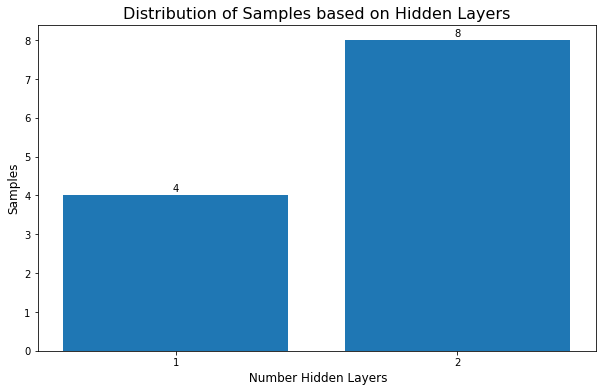

In [13]:
visualize_layer_distribution(score = coarse_score,sample = coarse_samples)

#### New range for learning rate and minibatch size

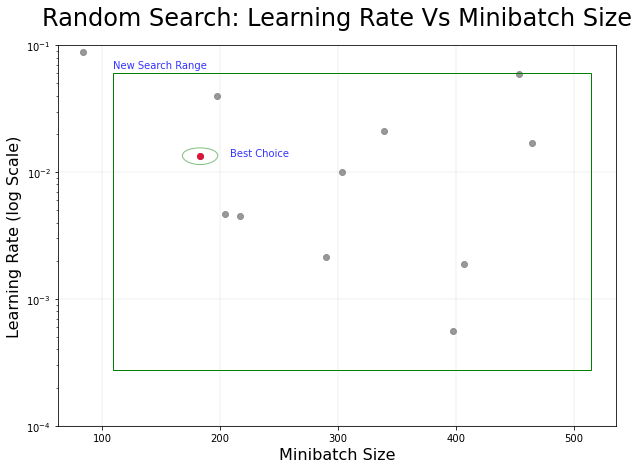

In [14]:
visualize_new_range(samples = coarse_samples, score = coarse_score, best_comb = coarse_best_comb, range_new = fine_search_param_new, range_old = search_param)

### Fine Search

In [15]:
fine_score, fine_samples, fine_best_comb, detailed_search_param_new = random_search(fine_search_param_new, search_type = "fine", sample_size = 12)


Sample: 1/12 -- Architecture:[816, 252] | Learning rate: 0.031413 | Minibatch size: 400 | keep_probs: 0.8
Training The Model...

Epoch 1/5
32/32 [==================== 100%] - 1.35s 42ms/step | loss: 3.9708 | acc: 0.6979 | val_loss: 0.4088 | val_acc: 0.8804
Epoch 2/5
32/32 [==================== 100%] - 1.37s 42ms/step | loss: 0.2776 | acc: 0.9198 | val_loss: 0.3610 | val_acc: 0.9062
Epoch 3/5
32/32 [==================== 100%] - 1.36s 42ms/step | loss: 0.2072 | acc: 0.9384 | val_loss: 0.2929 | val_acc: 0.9218
Epoch 4/5
32/32 [==================== 100%] - 1.36s 42ms/step | loss: 0.1777 | acc: 0.9485 | val_loss: 0.2779 | val_acc: 0.9271
Epoch 5/5
32/32 [==================== 100%] - 1.36s 42ms/step | loss: 0.1631 | acc: 0.9533 | val_loss: 0.2517 | val_acc: 0.9307

Total Training Time = 0hr 0mins 8secs 447.25ms

Sample: 2/12 -- Architecture:[280] | Learning rate: 0.000618 | Minibatch size: 471 | keep_probs: 0.8
Training The Model...

Epoch 1/5
28/28 [==================== 100%] - 0.39s 13ms/

30/30 [==================== 100%] - 1.72s 57ms/step | loss: 0.0654 | acc: 0.9817 | val_loss: 0.1507 | val_acc: 0.9564
Epoch 5/5
30/30 [==================== 100%] - 1.71s 57ms/step | loss: 0.0498 | acc: 0.9864 | val_loss: 0.1517 | val_acc: 0.9604

Total Training Time = 0hr 0mins 10secs 872.61ms

Sample: 10/12 -- Architecture:[588] | Learning rate: 0.008120 | Minibatch size: 373 | keep_probs: 0.9
Training The Model...

Epoch 1/5
35/35 [==================== 100%] - 0.81s 23ms/step | loss: 0.4465 | acc: 0.8625 | val_loss: 0.2525 | val_acc: 0.9262
Epoch 2/5
35/35 [==================== 100%] - 0.81s 23ms/step | loss: 0.1462 | acc: 0.9596 | val_loss: 0.1795 | val_acc: 0.9476
Epoch 3/5
35/35 [==================== 100%] - 0.81s 23ms/step | loss: 0.1009 | acc: 0.9716 | val_loss: 0.1670 | val_acc: 0.9502
Epoch 4/5
35/35 [==================== 100%] - 0.81s 23ms/step | loss: 0.0602 | acc: 0.9851 | val_loss: 0.1507 | val_acc: 0.9564
Epoch 5/5
35/35 [==================== 100%] - 0.81s 23ms/step | los

##### Sample Distribution based on hidden layers

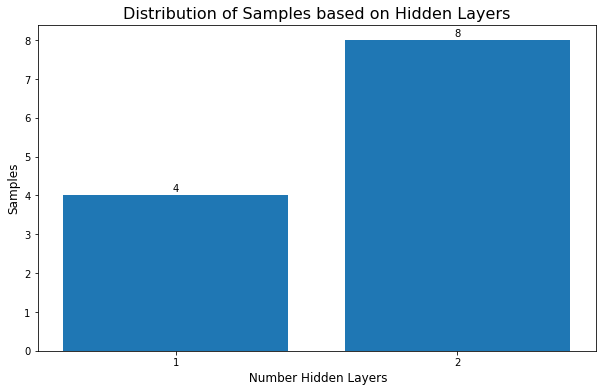

In [16]:
visualize_layer_distribution(score = fine_score,sample = fine_samples)

#### New range for learning rate and minibatch size

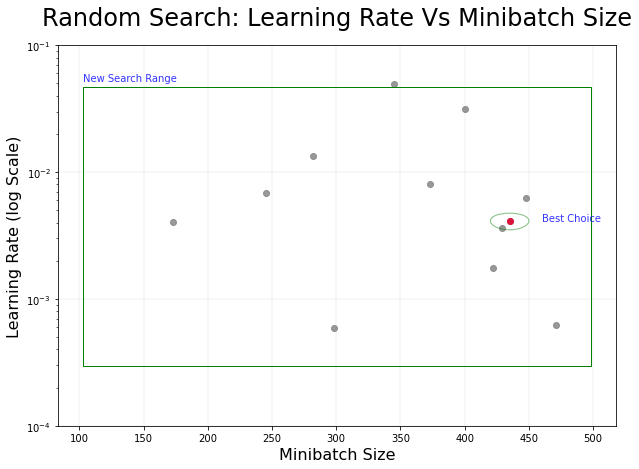

In [17]:
visualize_new_range(samples = fine_samples, score = fine_score, best_comb = fine_best_comb, range_new = detailed_search_param_new, range_old = fine_search_param_new)

### Detailed Search

In [18]:
detailed_score, detailed_samples, detailed_best_comb,search_param_new = random_search(detailed_search_param_new, search_type = "detail", sample_size = 12)


Sample: 1/12 -- Architecture:[560] | Learning rate: 0.009349 | Minibatch size: 425 | keep_probs: 0.5
Training The Model...

Epoch 1/10
30/30 [==================== 100%] - 0.70s 23ms/step | loss: 0.5595 | acc: 0.8331 | val_loss: 0.2815 | val_acc: 0.9133
Epoch 2/10
30/30 [==================== 100%] - 0.75s 24ms/step | loss: 0.1849 | acc: 0.9457 | val_loss: 0.2160 | val_acc: 0.9378
Epoch 3/10
30/30 [==================== 100%] - 0.73s 24ms/step | loss: 0.1283 | acc: 0.9631 | val_loss: 0.1733 | val_acc: 0.9493
Epoch 4/10
30/30 [==================== 100%] - 0.73s 24ms/step | loss: 0.0953 | acc: 0.9739 | val_loss: 0.1614 | val_acc: 0.9533
Epoch 5/10
30/30 [==================== 100%] - 0.73s 24ms/step | loss: 0.0760 | acc: 0.9784 | val_loss: 0.1561 | val_acc: 0.9533
Epoch 6/10
30/30 [==================== 100%] - 0.73s 24ms/step | loss: 0.0636 | acc: 0.9835 | val_loss: 0.1564 | val_acc: 0.9547
Epoch 7/10
30/30 [==================== 100%] - 0.73s 24ms/step | loss: 0.0528 | acc: 0.9842 | val_los

26/26 [==================== 100%] - 0.84s 32ms/step | loss: 1.6172 | acc: 0.7690 | val_loss: 0.3536 | val_acc: 0.9080
Epoch 2/10
26/26 [==================== 100%] - 0.85s 32ms/step | loss: 0.2474 | acc: 0.9319 | val_loss: 0.2609 | val_acc: 0.9320
Epoch 3/10
26/26 [==================== 100%] - 0.84s 32ms/step | loss: 0.1783 | acc: 0.9477 | val_loss: 0.2624 | val_acc: 0.9262
Epoch 4/10
26/26 [==================== 100%] - 0.84s 32ms/step | loss: 0.1481 | acc: 0.9566 | val_loss: 0.2129 | val_acc: 0.9431
Epoch 5/10
26/26 [==================== 100%] - 0.84s 32ms/step | loss: 0.1253 | acc: 0.9621 | val_loss: 0.2299 | val_acc: 0.9409
Epoch 6/10
26/26 [==================== 100%] - 0.84s 32ms/step | loss: 0.1162 | acc: 0.9656 | val_loss: 0.2279 | val_acc: 0.9449
Epoch 7/10
26/26 [==================== 100%] - 0.84s 32ms/step | loss: 0.1075 | acc: 0.9693 | val_loss: 0.2346 | val_acc: 0.9422
Epoch 8/10
26/26 [==================== 100%] - 0.84s 32ms/step | loss: 0.0912 | acc: 0.9739 | val_loss: 0.21

40/40 [==================== 100%] - 0.49s 12ms/step | loss: 0.1401 | acc: 0.9591 | val_loss: 0.1915 | val_acc: 0.9427
Epoch 4/10
40/40 [==================== 100%] - 0.49s 12ms/step | loss: 0.1053 | acc: 0.9707 | val_loss: 0.1575 | val_acc: 0.9556
Epoch 5/10
40/40 [==================== 100%] - 0.49s 12ms/step | loss: 0.0840 | acc: 0.9772 | val_loss: 0.1625 | val_acc: 0.9498
Epoch 6/10
40/40 [==================== 100%] - 0.49s 12ms/step | loss: 0.0720 | acc: 0.9804 | val_loss: 0.1634 | val_acc: 0.9502
Epoch 7/10
40/40 [==================== 100%] - 0.49s 12ms/step | loss: 0.0545 | acc: 0.9854 | val_loss: 0.1435 | val_acc: 0.9556
Epoch 8/10
40/40 [==================== 100%] - 0.49s 12ms/step | loss: 0.0469 | acc: 0.9868 | val_loss: 0.1486 | val_acc: 0.9564
Epoch 9/10
40/40 [==================== 100%] - 0.48s 12ms/step | loss: 0.0399 | acc: 0.9883 | val_loss: 0.1476 | val_acc: 0.9573
Epoch 10/10
40/40 [==================== 100%] - 0.49s 12ms/step | loss: 0.0305 | acc: 0.9926 | val_loss: 0.1

##### Sample Distribution based on hidden layers

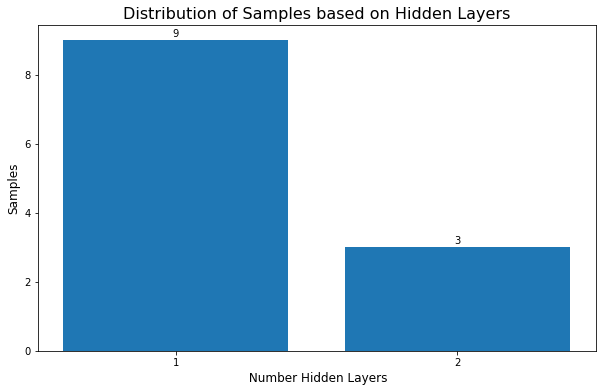

In [19]:
visualize_layer_distribution(score = detailed_score,sample = detailed_samples)

#### New range for learning rate and minibatch size

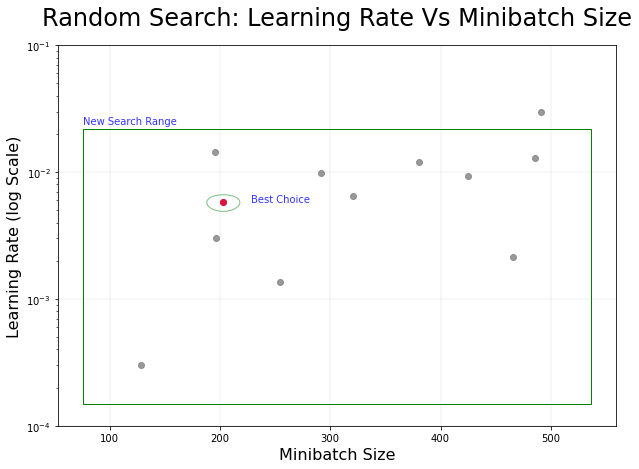

In [20]:
visualize_new_range(samples = detailed_samples, score = detailed_score, best_comb = detailed_best_comb, range_new = search_param_new, range_old = detailed_search_param_new)

## Saving the Notebook

In [21]:
!jupyter-nbconvert --to html 'Hyperparameter Tuning.ipynb' --output Experiments/hyperparameter_tuning_div_256_500_samples_complete_analysis.html 

[NbConvertApp] Converting notebook Hyperparameter Tuning.ipynb to html
[NbConvertApp] Writing 486384 bytes to Experiments/hyperparameter_tuning_div_256_500_samples_complete_analysis.html
